In [123]:
!pip install matplotlib
%matplotlib inline

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [124]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.nn.utils import spectral_norm

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [125]:
# Root directory for dataset
dataroot = "/workspace/imgs"
checkpoint_file_path = './checkpoint.tar'

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 25

# Learning rate for optimizers
lr_d = 1e-4
lr_g = 4e-4
betas = (0.0, 0.9)

# decay for exponential moving average
ema_decay = 0.9999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [126]:
# get the data
!apt update
!apt install wget unzip
if not os.path.isdir(dataroot):
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g9tAydWEN0PW-BYxdhNuGG9vXrdNzffA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g9tAydWEN0PW-BYxdhNuGG9vXrdNzffA" -O img_align_celeba.zip && rm -rf /tmp/cookies.txt
  !unzip img_align_celeba.zip -d /workspace/imgs

# load checkpoint data if it exists
have_checkpoint = False
checkpoint = None
completed_epochs = 0
if os.path.exists(checkpoint_file_path):
  checkpoint = torch.load(checkpoint_file_path)
  have_checkpoint = True
  completed_epochs = checkpoint['completed_epochs']

Hit:1 http://security.ubuntu.com/ubuntu xenial-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu xenial InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu xenial-updates InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu xenial-backports InRelease
Reading package lists... Done                  
Building dependency tree       
Reading state information... Done
105 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-20ubuntu1).
wget is already the newest

In [127]:
# calculate frechet inception distance
from torchvision.utils import save_image
from shutil import rmtree
num_batches = 100
real_images_for_fid_dir = "./fid_images/real/"
fake_images_for_fid_dir = "./fid_images/fake/"

if not os.path.isdir("pytorch-fid"):
    ! git clone https://github.com/mseitzer/pytorch-fid.git

def print_frechet_inception_distance():
    rmtree(real_images_for_fid_dir, ignore_errors=True)
    rmtree(fake_images_for_fid_dir, ignore_errors=True)
    os.makedirs(real_images_for_fid_dir)
    os.makedirs(fake_images_for_fid_dir)

    real_images = torch.cat([x[0] for _, x in zip(range(num_batches), iter(dataloader))])

    for i in range(real_images.size(0)):
        save_image(real_images[i, :, :, :], real_images_for_fid_dir + '{}.png'.format(i))

    with torch.no_grad():
        for batch_num in range(num_batches):
            generator_inputs = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG_ema(generator_inputs).detach().cpu()
            for i in range(fake_images.size(0)):
                save_image(fake_images[i, :, :, :], fake_images_for_fid_dir + '{}.png'.format(i + batch_num * batch_size))

    ! pytorch-fid/fid_score.py --batch-size 128 --gpu 0 ./fid_images/real/ ./fid_images/fake/

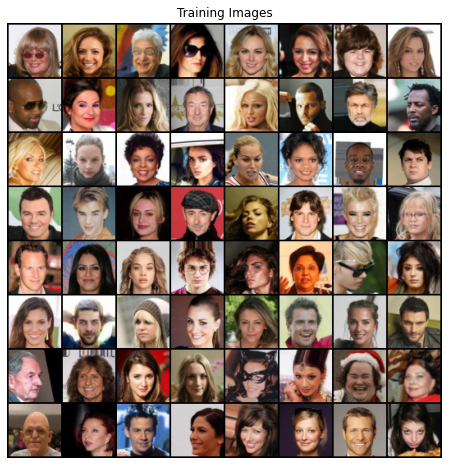

In [128]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [129]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [130]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = spectral_norm(nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1))
        self.key_conv = spectral_norm(nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1))
        self.value_conv = spectral_norm(nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1))
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

In [131]:
# Generator Code
class ResBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.skip_conv = spectral_norm(nn.ConvTranspose2d(self.in_channels, self.out_channels, 1, 2, 0))
        
        self.main_conv1 = spectral_norm(nn.ConvTranspose2d(self.in_channels, self.out_channels, 3, 2, 1, bias=False))
        self.main_bn = nn.BatchNorm2d(self.out_channels)
        self.main_relu = nn.ReLU(True)
        self.main_conv2 = spectral_norm(nn.ConvTranspose2d(self.out_channels, self.out_channels, 3, 1, 1, bias=False))
        
        self.out_bn = nn.BatchNorm2d(self.out_channels)
        self.out_relu = nn.ReLU(True)
        
        
    def forward(self, input):
        main = input
        skip = input
        
        skip = self.skip_conv(skip)
        
        main = self.main_conv1(main)
        main = self.main_bn(main)
        main = self.main_relu(main)
        main = self.main_conv2(main)
        
        out = main + skip
        out = self.out_bn(out)
        out = self.out_relu(out)
        return out


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            spectral_norm(nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
#             spectral_norm(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
            ResBlockUp(ngf * 8, ngf * 4),
            # state size. (ngf*4) x 8 x 8
            spectral_norm(nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            spectral_norm(nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            Self_Attn(ngf, 'relu'),
            # state size. (ngf) x 32 x 32
            spectral_norm(nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [132]:
# Create the generator
netG = Generator(ngpu).to(device)

# Create EMA generator
netG_ema = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

if not have_checkpoint:      
  # Apply the weights_init function to randomly initialize all weights
  #  to mean=0, stdev=0.2.
  netG.apply(weights_init)
else:
  netG.load_state_dict(checkpoint['netG_state_dict'])
  netG_ema.load_state_dict(checkpoint['netG_ema_state_dict'])

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ResBlockUp(
      (skip_conv): ConvTranspose2d(512, 256, kernel_size=(1, 1), stride=(2, 2))
      (main_conv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (main_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (main_relu): ReLU(inplace)
      (main_conv2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (out_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (out_relu): ReLU(inplace)
    )
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [133]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.ReLU(True),
            Self_Attn(ndf, 'relu'),
            # state size. (ndf) x 32 x 32
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.ReLU(True),
            # state size. (ndf*2) x 16 x 16
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.ReLU(True),
            # state size. (ndf*4) x 8 x 8
            spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.ReLU(True),
            # state size. (ndf*8) x 4 x 4
            spectral_norm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
        )

    def forward(self, input):
        return self.main(input)

In [134]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

if not have_checkpoint:      
  # Apply the weights_init function to randomly initialize all weights
  #  to mean=0, stdev=0.2.
  netD.apply(weights_init)
else:
  netD.load_state_dict(checkpoint['netD_state_dict'])

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): Self_Attn(
      (query_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (key_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (value_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax()
    )
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): ReLU(inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): ReLU(inplace)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): ReLU(inplace)
    (9): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [135]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=betas)
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=betas)

if have_checkpoint:
  optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
  optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])

In [136]:
# Training Loop
from datetime import datetime
import math

start_time = datetime.now()

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

final_epoch = num_epochs + completed_epochs

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = torch.nn.ReLU()(1.0 - output).mean()
        D_x = errD_real.item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        
        print(fake.size())
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = torch.nn.ReLU()(1.0 + output).mean()
        D_G_z1 = errD_fake.item()

        errD = errD_fake + errD_real
        errD.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = - output.mean()
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = errG.item()
        # Update G
        optimizerG.step()
        # update netG_ema
        with torch.no_grad():
            for key in netG.state_dict():
                netG_ema.state_dict()[key].data.copy_(netG_ema.state_dict()[key] * ema_decay
                                                     + netG.state_dict()[key] * (1 - ema_decay))
        
        # Output training stats
        if i % math.ceil(len(dataloader) / 5) == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (1 + completed_epochs, final_epoch, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
            
        iters += 1

    # save models and optimizers
    completed_epochs += 1
    torch.save({
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'netG_ema_state_dict': netG_ema.state_dict(),
                'completed_epochs': completed_epochs}, checkpoint_file_path)
    
    if completed_epochs % 5 == 0:
        print_frechet_inception_distance()

print("training time: " + str(datetime.now() - start_time))

Starting Training Loop...
torch.Size([128, 3, 56, 56])


RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
with torch.no_grad():
    fake = netG_ema(fixed_noise).detach().cpu()

fakes = vutils.make_grid(fake, padding=2, normalize=True)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fakes,(1,2,0)))
plt.show()